# Marital Status
Authors: [RedSkittleFox](https://github.com/RedSkittleFox), [DJAltair](https://github.com/DJAltair)

# Get the Data

## Load the Data

In [24]:
import os
import pandas as pd
import numpy as np 

marital_data : pd.DataFrame = pd.read_csv(os.path.join("data", "marital_data.csv"), sep=",")
marital_data.head()

,Year,Marital status
0,1,S
1,2,S
2,5,M
3,1,S
4,4,M


# Prepare the Data

We begin the data preparation by converting the categorical data to binary ones and zeros according to `W = 0` and `M = 1` mapping. In the next step we calculate the probability of being in a relationship based on the collage year.

In [25]:
# Remap categorical data to binary data.
def binary(x):
    if x == 'S': return 0
    return 1
marital_data["Marital numeric"] = marital_data["Marital status"].transform(binary)

# Calculate probabilities
marital_data = marital_data.groupby("Year")["Marital numeric"].agg(["count", "sum"]).reset_index()
marital_data.columns = ["Year", "Occurrences", "Married"]
marital_data['Probability'] = (marital_data["Married"]/marital_data["Occurrences"])
marital_data.head()

,Year,Occurrences,Married,Probability
0,1,6,1,0.166667
1,2,6,1,0.166667
2,3,5,3,0.600000
3,4,5,4,0.800000
4,5,6,5,0.833333


# Linear Regression
We start by preparing and evaluating the linear regression model.
$$
    \text{Probability}(\text{Year}) = 0.19667 \cdot \text{Year} - 0.07667
$$

Coef = [0.19666667]
Intercept = -0.07666666666666666


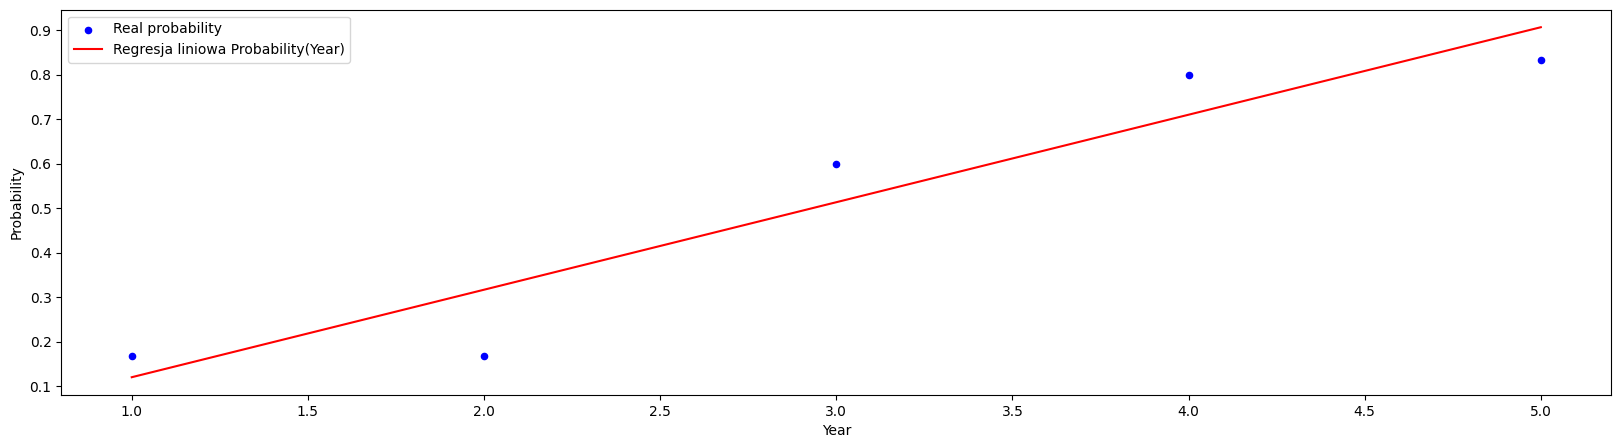

In [26]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

X = marital_data[["Year"]].copy()
Y = marital_data["Probability"].copy()

lin_reg = LinearRegression()
lin_reg.fit(X, Y)
Y_predicted = lin_reg.predict(X)
print(f"Coef = {lin_reg.coef_}")
print(f"Intercept = {lin_reg.intercept_}")

#rozmiar kropki
plot = marital_data[["Year", "Probability"]].plot.scatter(x="Year", y="Probability", figsize=(20, 5), color='b', label="Real probability")
plot.plot(X, Y_predicted, color='r', label="Regresja liniowa Probability(Year)")
plot.legend()
plot;

# Logistic Regression
Using the probabilities of being in a relationship based on a collage year we calculate the logic -  afunction that converts probability into the logarithm of chance.

$$
p(\text{Year}) = \frac{\text{number of students in a relationship in the given year}}{\text{number of observations in the given year}}
$$
$$
\text{chance} = \frac{p}{1 - p}
$$
$$
\text{logit}(p) = \ln \text{chance}_p = \ln \frac{p}{1 - p}
$$

In order to use the logit function in the logistic regression we equate it to the linear function equation.
$$
\text{logit}(p(\text{Year})) = \ln \frac{p}{1 - p} = \alpha_0 + \alpha_1 \cdot \text{Year}
$$

In [27]:
# Compute logit
logit_data = marital_data
logit_data['Logit'] = np.log(logit_data["Probability"] / (1 - logit_data["Probability"]))

X = logit_data[["Year"]].copy()
Y = logit_data["Logit"]

logit_reg = LinearRegression()
logit_reg.fit(X,Y)
logit_coef = logit_reg.coef_
logit_intercept = logit_reg.intercept_
print(f"Coef = {logit_coef}")
print(f"Intercept = {logit_intercept}")


Coef = [0.94334839]
Intercept = -2.7935808656283285


$$
\text{logit}(p(\text{Year})) = -2.79358 + 0.94335 \cdot \text{Year}
$$
$$
p(\text{Year}) = \frac{1}{1 + \exp(-\text{logit}(p(\text{Year}))) } = \frac{1}{1 + \exp(2.79358 - 0.94335 \cdot \text{Year})}
$$

In [28]:
# Prediction function
def predict(X_):
    return 1 / (1 + np.exp(-(logit_intercept + logit_coef * X_)))

Y = predict(X)
Y

,Year
0,0.135846
1,0.287638
2,0.509115
3,0.727071
4,0.872491


# Visualization

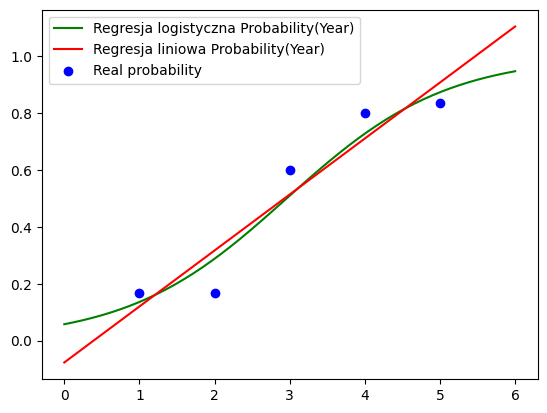

In [29]:
import matplotlib.pyplot as plt
X_data = np.linspace(0, 6)
Y_data = predict(X_data)

X_linear_data = pd.DataFrame({"Year" : X_data})
Y_linear_data = lin_reg.predict(X_linear_data)

plt.plot(X_data, Y_data, color="g", label="Regresja logistyczna Probability(Year)")
plt.plot(X_linear_data, Y_linear_data, color='r', label="Regresja liniowa Probability(Year)")
plt.scatter(logit_data['Year'], logit_data['Probability'], color='b', label="Real probability")
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Y_data = logit_data['Probability']
Y_linear_data = lin_reg.predict(logit_data[["Year"]])
Y_logit_data = predict(logit_data["Year"])

R2_score_linear = r2_score(Y_data, Y_linear_data)
RMSE_linear = np.sqrt(mean_squared_error(Y_data, Y_linear_data))

R2_score_logit = r2_score(Y_data, Y_logit_data)
RMSE_logit = np.sqrt(mean_squared_error(Y_data, Y_logit_data))

print(f"Linear : R2 = {R2_score_linear} : RMSE = {RMSE_linear}")
print(f"Logit : R2 = {R2_score_logit} : RMSE = {RMSE_logit}")

Linear : R2 = 0.894398766700925 : RMSE = 0.09556847457887636
Logit : R2 = 0.9290175671683631 : RMSE = 0.07835299449439352


Both models predict the probability of a marital status based on the year. Linear model however fails to predict the probability for the years outside of the training range. The logistic model, which is based on the logit function, yields more accurate predictions. Despite both models showing similar R2 and RMSE metrics the logistic models were more closely fitted to the data and more closely resembled the analyzed topic. 